# Python Analytics Project: Analysis of the drivers outflow

## Problem

There is data from taxi company (uber) that wants to study the outflow of drivers and see what differences there are between drivers who leave the service and who stay. It is necessary to formulate and test hypotheses, identify groups of drivers who are most susceptible to "churn" and conduct statistical tests. Based on the results, it is necessary to draw conclusions about what can be improved in the service in order to make changes in the future.

## Assumptions

Perhaps the outflow of users is due to the difference in the usability of the application on Android and iPhone. It may also be related to the city of application usage. It is also possible that the outflow is associated with drivers activity in the first 30 days.

## Data

- __city__
- __phone__ – the main device that the driver uses;
- __signup_date__ – account registration date (`YYYYMMDD`);
- __last_trip_date__ – date of last ride (`YYYYMMDD`);
- __avg_dist__– average distance (in miles) per ride in the first 30 days after registration;
- __avg_rating_by_driver__ – average rating of ride by the driver;
- __avg_rating_of_driver__ – average rating of the driver's rides;
- __surge_pct__ – percentage of rides made with a multiplier > 1 (when there is a heavy workload, etc.);
- __avg_surge__ – average surge multiplier for all this driver's trips;
- __trips_in_first_30_days__ – the number of rides that the driver made in the first 30 days after registration
- __luxury_car_user__ – TRUE if the user used a premium car in the first 30 days
- __weekday_pct__ – percentage of user trips made on weekdays

## Analysis
### Data preprocessing

In [28]:
# importing libraries
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2
from scipy import stats

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [29]:
# reading tables and saving to dataframe
df = pd.read_csv('churn.csv')

Let's take a look at the appearence of the table

In [30]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

In [31]:
df.shape

(50000, 12)

In [32]:
# checking for empty values
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

Empty values in fields "avg_rating_by_driver" and "avg_rating_of_driver" aren't an anomaly in the data, because the average is calculated when a certain number of rides have been completed.

Empty values in field "phone" can be evidence that some drivers use phones on a different operating system.

In [33]:
# checking the data type
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

We see that fields "last_trip_date", "signup_date" have object data type, we need to change it to datetime type

In [34]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

### Churn

Creating a churn label - we devide drivers into to groups: those who stayed and those who left the service (we consider that the user has left the service if he has not been active for the last 30 days)

In [36]:
# determing the number of days since the last trip
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date
df['days_since_last_trip']

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

In [37]:
# changing datetype
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [38]:
# creating churn label
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

days_since_last_trip      churn
0                        14  not_churn
1                        57      churn
2                       175      churn
3                         2  not_churn
4                       108      churn
...                     ...        ...
49995                    26  not_churn
49996                   157      churn
49997                    40      churn
49998                   167      churn
49999                    72      churn

[50000 rows x 2 columns]

In [39]:
# determing percentage ratio
df.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

In [40]:
# plotting a chart with the results
fig = px.histogram(df, x='churn')
fig.show()

Let's reflect also the normalized values on the graph

In [41]:
fig = px.histogram(df, x='churn', histnorm='probability density')
fig.show()

We see that a large number of users have not used the service in the last month. We need to figure out what factors can influence the outflow of drivers

### Churn & Phone

Let's assume that the problem may be among users on a particular platform

In [42]:
pd.crosstab(df.churn, df.phone)

phone      Android  iPhone
churn                     
churn        11876   19057
not_churn     3146   15525

In [43]:
# plotting a chart with the results
fig = px.histogram(df[['churn', 'phone']].dropna(), x='churn', 
                   color='phone')
fig.show()

We can see that the number of drivers who left is much bigger amoung android users. But it is not very good to make a conclusion only according to the schedule, so we will test our hypothesis using a statistical test.

We have two categorical variables → we will use chi-square

- $H_0$: there is no relationship between variables
- $H_1$: there is relationship

In [44]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))
stat, p

(2558.394212267425, 0.0)

P-value < 0,05 

So we can reject H0 and we see that there is relationship between variables. It means that something went wrong with android users

### Churn & City
Also we'll check drivers outflow in different cities 

In [45]:
pd.crosstab(df.churn, df.city)

city       Astapor  King's Landing  Winterfell
churn                                         
churn        12306            3767       15123
not_churn     4228            6363        8213

We have two categorical variables → we will use chi-square

- $H_0$: there is no relationship between variables
- $H_1$: there is relationship

In [46]:
# plotting a chart with the results
fig = px.histogram(df[['churn', 'city']].dropna(), x='churn', 
                   color='city')
fig.show()

In [47]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))
stat, p

(3821.5510225559633, 0.0)

P-value < 0

So we can reject H0 and can see that there is also relationship between churn and city

### Churn & Days
We'll check if the outflow is associated with drivers activity in the first 30 day

First of all we need to check a distribution

In [48]:
stats.shapiro(df[df['churn'] == 'churn']['trips_in_first_30_days'].sample(1000, random_state=17))

ShapiroResult(statistic=0.4566316604614258, pvalue=0.0)

In [49]:
stats.shapiro(df[df['churn'] == 'not_churn']['trips_in_first_30_days'].sample(1000, random_state=17))

ShapiroResult(statistic=0.6462708711624146, pvalue=3.391983062744652e-41)

In [50]:
churn = df[df.churn == 'churn'].trips_in_first_30_days
not_churn = df[df.churn == 'not_churn'].trips_in_first_30_days

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



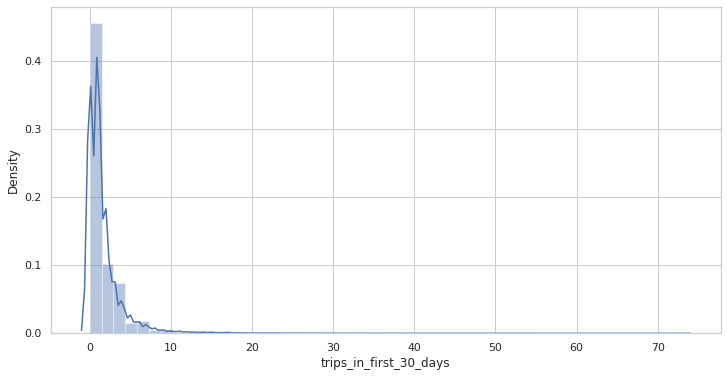

In [51]:
sns.distplot(churn)

Distributions deviate from normal

So we conduct the Mann-Whitney test

In [52]:
ss.mannwhitneyu(df[df['churn'] == 'churn']['trips_in_first_30_days'], df[df['churn'] == 'not_churn']['trips_in_first_30_days'])

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

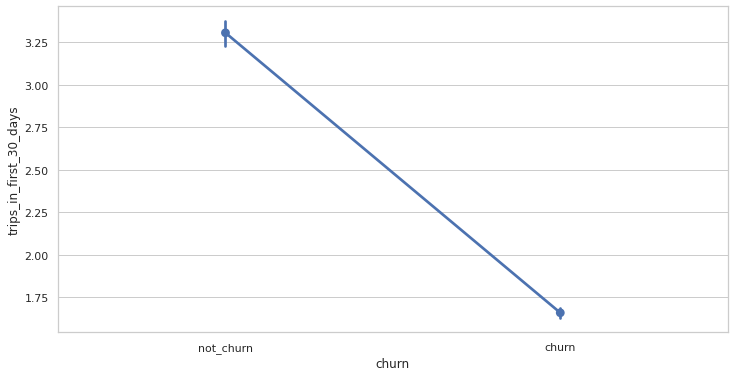

In [53]:
sns.pointplot(x = 'churn', y = 'trips_in_first_30_days', data = df)

There are significant differences, the users who left the app were less active

## Suggestions

__1.__ Since we have identified the large outflow of drivers among android users, there is a proposal to conduct an A/B test, where some android users will have the previous version of the application and the rest will have new version and compare the results between these two groups

__2.__ As there are differences among users in different cities, it may be due to the level of payment. It can be proposed to improve the bonus program for drivers in the cities with the largest outflow

__3.__ Since we have identified the large outflow of drivers who were less active in a first month of using the app, there is a proposal to improve the loyalty program and target and motivate not very active drivers